In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torchvision.transforms.functional as F

import numpy as np
import os
import argparse
from pathlib import Path
import matplotlib.pyplot as plt
import re
from typing import NamedTuple

from utils.data import Data
from utils.manager import set_seed, set_cuda, fetch_paths, set_logger, set_device, RunManager
from utils.fourier import ifft2c as ift
from utils.fourier import fft2c as ft
from utils.math import complex_abs
from utils.mask import apply_random_mask

from models.miccan import MICCAN

In [2]:
# TRANSFORM CLASS
class Sample(NamedTuple):
    kspace: torch.Tensor
    kspace_und: torch.Tensor
    mask: torch.Tensor
    image_zf: torch.Tensor
    image_zf2: torch.Tensor
    target: torch.Tensor
    target2: torch.Tensor
    fname: str
    slice_num: int
    sequence: str


class Transform:

    def __init__(self, train, mask_type, accelerations):
        self.train = train
        self.mask_type = mask_type
        self.accelerations = accelerations

    def __call__(self, kspace_ori, fname, slice_num, sequence):
        target2 = ift(kspace_ori)

        # cover 1/4
        target2[0:160, 0:160, 0:2] = 0
        target2[160:320, 160:320, 0:2] = 0
        target2[0:160, 160:320, 0:2] = 0

        kspace_ori = ft(target2)

        target = complex_abs(target2)

        seed = int("".join(re.findall(r"\d+", fname))) if not self.train else None

        if self.mask_type == 'random':
            kspace_und, mask = apply_random_mask(kspace_ori, self.accelerations, seed)
        else:
            kspace_und = kspace_ori
            mask = None

        image_zf2 = ift(kspace_und)
        image_zf = complex_abs(image_zf2)

        sample = Sample(
            kspace=kspace_ori.permute(2, 0, 1),
            kspace_und=kspace_und.permute(2, 0, 1),
            mask=mask.unsqueeze(0),
            image_zf=image_zf.unsqueeze(0),
            image_zf2=image_zf2.permute(2, 0, 1),
            target=target.unsqueeze(0),
            target2=target2.permute(2, 0, 1),
            fname=fname,
            slice_num=slice_num,
            sequence=sequence
        )

        return sample

In [3]:
# ARGUMENTS
class Arguments():
    def __init__(self):
        self.acc = [4]
        self.mtype = 'random'
        self.dset = 'fastmribrain'
        self.blocktype = 'UCA'
        self.nblock = 5
        self.in_channels = 2
        self.out_channels = 2
        self.model_name = 'Experiment_2022_09_16_13_45_14'
        self.fname = 'file_brain_AXFLAIR_200_6002447'
        self.slice_id = 0
        
args = Arguments()

In [4]:
# path for the experiments
data_path, _ = fetch_paths(args.dset)
exp_path = Path("D:\Trained models")
ckpt = torch.load(os.path.join(exp_path, args.model_name, f'{args.model_name}_model.pth'), map_location='cpu')

In [5]:
# data
transform = Transform(train=False, mask_type=args.mtype, accelerations=args.acc)
data = torch.load(os.path.join(data_path, "val", f"{args.fname}.pt"))
kspace = data["kspace"][args.slice_id]
sequence = data["sequence"]
sample = transform(kspace, args.fname, args.slice_id, sequence)

In [6]:
# model
model = MICCAN(args)
model.load_state_dict(ckpt['last_model_state_dict'])
model = model.to('cuda').eval()

In [7]:
# forward pass
with torch.no_grad():
    xu1 = sample.image_zf.unsqueeze(0).to('cuda')
    xu = sample.image_zf2.unsqueeze(0).to('cuda')
    x = sample.target.unsqueeze(0).to('cuda')
    yu = sample.kspace_und.unsqueeze(0).to('cuda')
    msk = sample.mask.unsqueeze(0).to('cuda')
    # fname = sample.fname
    # slice_num = sample.slice_num
    # sequence = sample.sequence
    x_hat, x_hat2 = model(xu, yu, msk)

In [8]:
inp = xu1.squeeze(0).squeeze(0).flip([0]).to('cpu')
out = x_hat.squeeze(0).squeeze(0).flip([0]).to('cpu')
ref = x.squeeze(0).squeeze(0).flip([0]).to('cpu')

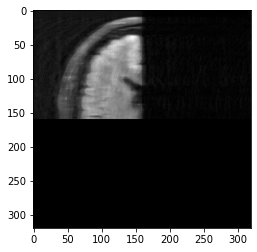

In [9]:
plt.imshow(inp, cmap='gray'); plt.show()

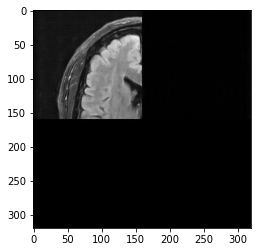

In [10]:
plt.imshow(out, cmap='gray'); plt.show()

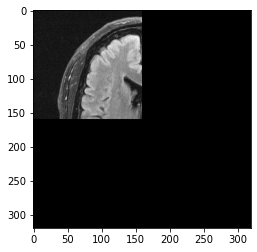

In [11]:
plt.imshow(ref, cmap='gray'); plt.show()